#Install

In [ ]:
!pip install -q datasets transformers accelerate

In [2]:
from datasets import Dataset, Image, ClassLabel, load_dataset
from collections import defaultdict
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm, trange

In [3]:
SEED = 22
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

In [ ]:
data_sets = load_dataset("Mauregato/affectnet_short")

In [5]:
val_set = data_sets['val']
splits = val_set.train_test_split(test_size=0.2, shuffle=True, stratify_by_column='label')
train_set, test_set = splits['train'], splits['test']

In [6]:
labels = data_sets['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
id2label[2]

'contempt'

#Tune HP

In [ ]:
!pip install -q wandb

In [ ]:
import wandb
wandb.login()


%env WANDB_PROJECT=vit_emotions_sweeps
%env WANDB_LOG_MODEL='end'

In [9]:
model_checkpoint = "google/vit-base-patch16-224" 

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

In [11]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [ 
            RandomResizedCrop((feature_extractor.size['height'],
                               feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], 
                    feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'],
                        feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB"))for image in example_batch["image"]
    ]
    return example_batch

In [12]:
train_set.set_transform(preprocess_train)
test_set.set_transform(preprocess_val)

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
def model_init():
    vit_model = AutoModelForImageClassification.from_pretrained(
        model_checkpoint,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    return vit_model

In [18]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'eval/accuracy',
        'goal': 'maximize'
    }
}

# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 1
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='vit-emotions-sweeps')

In [19]:
from datasets import load_metric
import numpy as np


def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')


  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))


  return metrics

In [20]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
def train(config=None):
  with wandb.init(config=config):
    # set sweep configuration
    config = wandb.config


    # set training arguments
    training_args = TrainingArguments(
        output_dir='vit-sweeps',
	      report_to='wandb',  # Turn on Weights & Biases logging
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
        fp16=True
    )


    # define training loop
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_set,
        eval_dataset=test_set,
        compute_metrics=compute_metrics_fn
    )


    # start training loop
    trainer.train()

In [ ]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: 3siiscf1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.00035901610938824204
wandb: 	weight_decay: 0
wandb: Currently logged in as: nalex22-uv-j02. Use `wandb login --relogin` to force relogin


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.443400,1.070609,0.567126,0.565308,0.567126,0.559784


<ipython-input-16-e6c0cd5581dc>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: m3dhisqt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 5.2542052027776035e-05
wandb: 	weight_decay: 0.2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.564500,1.292496,0.497418,0.498415,0.497418,0.489131


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 1hdtx8qh with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1
wandb: 	learning_rate: 9.410295294995392e-05
wandb: 	weight_decay: 0.5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.344700,1.028369,0.580895,0.587694,0.580895,0.570566


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: h8ejjs4r with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1
wandb: 	learning_rate: 2.727695031227233e-05
wandb: 	weight_decay: 0.2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.505100,1.217268,0.537866,0.529308,0.537866,0.528830


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 3l75t819 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	learning_rate: 4.033641812127156e-05
wandb: 	weight_decay: 0.2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.362200,1.057467,0.585198,0.583012,0.585198,0.576163


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 7fptx16v with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1
wandb: 	learning_rate: 1.2920596587327232e-05
wandb: 	weight_decay: 0.3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.692100,1.467338,0.416523,0.415406,0.416523,0.408576


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: oht4dns5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	learning_rate: 6.500774940342642e-05
wandb: 	weight_decay: 0.3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.419200,1.110409,0.580895,0.577832,0.580895,0.574428


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: r0umyyqu with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0002374074344127723
wandb: 	weight_decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.514300,1.139534,0.535284,0.553313,0.535284,0.518755


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 8ccerxmg with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 5.1260377556228e-05
wandb: 	weight_decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.573800,1.304646,0.480207,0.480220,0.480207,0.471442


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: jkrclqt6 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0003247788840250586
wandb: 	weight_decay: 0.4


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.508100,1.147008,0.534423,0.538345,0.534423,0.516847


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: radr6yp3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0009042044651882598
wandb: 	weight_decay: 0.3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.084100,2.043053,0.179862,0.079544,0.179862,0.062979


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 3hsiua2m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0002331492303185939
wandb: 	weight_decay: 0.3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.375700,1.048179,0.567986,0.568696,0.567986,0.557712


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: l4g305t6 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	learning_rate: 0.00011422376559602587
wandb: 	weight_decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-st

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.339400,1.009081,0.598107,0.602009,0.598107,0.588209


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: e7vvzswh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0008843809145920322
wandb: 	weight_decay: 0.4


In [ ]:
wandb.finish()

#Train

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [22]:
model_checkpoint = "google/vit-base-patch16-224"

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

In [24]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [ 
            RandomResizedCrop((feature_extractor.size['height'],
                               feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], 
                    feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'],
                        feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
data_sets = load_dataset("Mauregato/affectnet_short")

In [26]:
train_set, test_set = data_sets['train'], data_sets['val']

In [27]:
train_set.set_transform(preprocess_train)
test_set.set_transform(preprocess_val)

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, 
)

In [16]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-on-all-affectnet_short",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    label_smoothing_factor=0.1,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=14,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [29]:
from datasets import load_metric
import numpy as np


def compute_metrics(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')


  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))


  return metrics

In [30]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [31]:
from transformers import EarlyStoppingCallback
callback = EarlyStoppingCallback(early_stopping_patience=7, 
                                 early_stopping_threshold=0.0001)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_set,
    eval_dataset=test_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.539900,1.469806,0.509726,0.507856,0.509726,0.482689
2,1.284000,1.202583,0.640902,0.651385,0.640902,0.622564
3,1.225900,1.136717,0.672233,0.674949,0.672233,0.669432
4,1.166300,1.108644,0.683767,0.690293,0.683767,0.681446
5,1.140100,1.078163,0.705457,0.706968,0.705457,0.704178
6,1.122900,1.073373,0.705457,0.709308,0.705457,0.703570
7,1.092900,1.067384,0.711999,0.714729,0.711999,0.709925
8,1.082600,1.060091,0.720950,0.722589,0.720950,0.719058
9,1.041400,1.055825,0.720262,0.721074,0.720262,0.719602
10,1.064900,1.049896,0.717852,0.719382,0.717852,0.717527


<ipython-input-13-9f2fe9c66865>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/repository.py:1271 in is_repo_clean      │
│                                                                                                  │
│   1268 │   │   │   `bool`: `True` if the git status is clean, `False` otherwise.                 │
│   1269 │   │   """                                                                               │
│   1270 │   │   try:                                                                              │
│ ❱ 1271 │   │   │   git_status = run_subprocess("git status --porcelain", self.local_dir).stdout  │
│   1272 │   │   except subprocess.CalledProcessError as exc:                                      │
│   1273 │   │   │   raise EnvironmentError(exc.stderr)                                            │
│   1274                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_subprocess.py:83 in               │
│ run_subprocess                                                                                   │
│                                                                                                  │
│    80 │   if isinstance(folder, Path):                                                           │
│    81 │   │   folder = str(folder)                                                               │
│    82 │                                                                                          │
│ ❱  83 │   return subprocess.run(                                                                 │
│    84 │   │   command,                                                                           │
│    85 │   │   stderr=subprocess.PIPE,                                                            │
│    86 │   │   stdout=subprocess.PIPE,                                                            │
│                                                                                                  │
│ /usr/lib/python3.10/subprocess.py:526 in run                                                     │
│                                                                                                  │
│    523 │   │   │   raise                                                                         │
│    524 │   │   retcode = process.poll()                                                          │
│    525 │   │   if check and retcode:                                                             │
│ ❱  526 │   │   │   raise CalledProcessError(retcode, process.args,                               │
│    527 │   │   │   │   │   │   │   │   │    output=stdout, stderr=stderr)                        │
│    528 │   return CompletedProcess(process.args, retcode, stdout, stderr)                        │
│    529                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
CalledProcessError: Command '['git', 'status', '--porcelain']' returned non-zero exit status 128.

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2870 in save_model               │
│                                                                                                  │
│   2867 │   │                                                                                 

In [ ]:
trainer.save_model()
trainer.save_state()

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       14.0
  eval_accuracy           =     0.7259
  eval_f1                 =     0.7255
  eval_loss               =      1.052
  eval_precision          =     0.7293
  eval_recall             =     0.7259
  eval_runtime            = 0:01:17.92
  eval_samples_per_second =     74.546
  eval_steps_per_second   =      4.671


In [ ]:
trainer.push_to_hub()

#Forward

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("Mauregato/vit-base-patch16-224-finetuned-on-all-affectnet_short")

model = AutoModelForImageClassification.from_pretrained("Mauregato/vit-base-patch16-224-finetuned-on-all-affectnet_short")

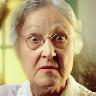

In [41]:
from PIL import Image
import requests

url = 'https://datasets-server.huggingface.co/assets/Mauregato/affectnet_short/--/Mauregato--affectnet_short/train/35/image/image.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [42]:
encoding = extractor(image.convert("RGB"), return_tensors="pt")

In [43]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [44]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: fear
